In [ ]:
# ----------------------------------------------
#           ***  MOUNT DRIVE  ***
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Mount.txt', 'r') as file:
    print(file.read())
# ==============================================

Mounted at /content/drive
Mount successful!


In [ ]:
# ----------------------------------------------
#          ***  IMPORTS BASIC  ***
from os import listdir, mkdir 
from os.path import isfile, join, exists
import pickle
import random
import datetime
import time
import math

def seconds_to_m_s(seconds):
    minutes = math.floor(seconds // 60)
    seconds = math.ceil(seconds % 60)
    return minutes, seconds

start_work = time.time()
print('Start work at:', datetime.datetime.now().strftime("%H:%M:%S %Y.%m.%d"))
print("\nAll work took {} minutes {} seconds".format(*seconds_to_m_s(time.time() - start_work)))
# ==============================================

Start work at: 10:11:41 2020.10.06

All work took 0 minutes 1 seconds


In [ ]:
# ----------------------------------------------
#         ***  IMPORTS PROJECT  ***
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
# ==============================================

In [ ]:
# ----------------------------------------------
#            ***  DIRECTORY  ***
base_dir = '/content/drive/My Drive/'
dataset_dir = join(base_dir, 'Datasets', 'jena_climate')
file_path = join(dataset_dir, 'jena_climate_2009_2016.csv')
# ==============================================

In [ ]:
df = pd.read_csv(file_path)
# df.head()

In [ ]:
head_list = list(df.columns)
print(head_list)

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))

print('len_train:', train_split, '/', df.shape[0])

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

len_train: 300693 / 420551


In [ ]:
features = df['T (degC)']
features.index = df['Date Time']
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]
print('train_data', train_data.shape)
print('val_data', val_data.shape)

train_data (300693, 1)
val_data (119858, 1)


In [ ]:
data_mean = df['T (degC)'].values[:train_split].mean(axis=0)
print(data_mean)
data_std = df['T (degC)'].values[:train_split].std(axis=0)
print(data_std)

9.250203962180695
8.635015642805945


In [ ]:
step = 6                # 1 hour
past = 720              # 5 days
future = 72             # 12 hour
learning_rate = 0.001
batch_size = 256
epochs = 10

start = past + future       # 720 + 72 = 5,5 days 
end = start + train_split   # 792 + 300693 = 301485

x_train = train_data[[i for i in range(train_data.shape[1])]].values    # все треннировочные значения по всем колонкам
y_train = features.iloc[start:end]     # температура с 792 по 301485

sequence_length = int(past / step)

print('start', start)
print('end', end)
print('sequence_length', sequence_length)
print('x_train', x_train.shape)
print('y_train', y_train.shape)

start 792
end 301485
sequence_length 120
x_train (300693, 1)
y_train (300693, 1)


In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
print('dataset_train', dataset_train)

dataset_train <BatchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [ ]:
x_end = len(val_data) - past - future
print('len(val_data)', len(val_data))
print('past', past)
print('future', future)
print('x_end:', x_end)

label_start = train_split + past + future
print('train_split:', train_split)
print('label_start:', label_start)

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

print('dataset_val:', dataset_val)

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

len(val_data) 119858
past 720
future 72
x_end: 119066
train_split: 300693
label_start: 301485
dataset_val: <BatchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
Input shape: (256, 120, 1)
Target shape: (256, 1)


In [ ]:
# ----------------------------------------------
#          ***  CLEAR SESSION  ***
# not run
from tensorflow.keras import backend as K
del model
K.clear_session()
# ==============================================

In [ ]:
from tensorflow.keras.regularizers import L2
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# lstm_out = keras.layers.LSTM(64)(inputs)
# lstm_out = keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)(inputs)

# lstm_out = keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(inputs)
# lstm_out = keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(lstm_out)

# lstm_out = keras.layers.LSTM(16, kernel_regularizer=L2(l2=0.01),
#     recurrent_regularizer=L2(l2=0.01), bias_regularizer=L2(l2=0.01))(inputs)

lstm_out = keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
not run
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file=join(base_dir, 'model_lstm_01.png'))

In [ ]:
not run
%%time
start_work = time.time()
print('Start work at:', datetime.datetime.now().strftime("%H:%M:%S %Y.%m.%d"))

save_index = '16' # only temperature

path_checkpoint = join(dataset_dir, "model_checkpoint_{}.h5".format(save_index))
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

print("\nAll work took {} minutes {} seconds".format(*seconds_to_m_s(time.time() - start_work)))

In [ ]:
# not run
model.load_weights(join(dataset_dir, "model_checkpoint_09.h5"))

In [ ]:
%%time
validation = model.evaluate(dataset_val, verbose=1, return_dict=True)
print(validation)
mae = validation['mae'] * data_std + data_mean
print(mae, 'degC')
# print('mae = {0:.2f} degC, erorr = {1:.02f} %'.format(mae, mae*100/t_range))

463/463 [==============================] - 20s 42ms/step - loss: 0.1385 - mae: 0.2940
{'loss': 0.13852207362651825, 'mae': 0.2940007746219635}
11.788905250038415 degC
CPU times: user 28.5 s, sys: 7.31 s, total: 35.8 s
Wall time: 20.4 s


In [ ]:
t_min = df['T (degC)'].min(axis=0)
t_max = df['T (degC)'].max(axis=0)
t_range = np.abs(t_min) + np.abs(t_max)
print('t_min', t_min)
print('t_max', t_max)
print('t_range', round(t_range, 2))
print('mae = {0:.2f} degC, erorr = {1:.02f} %'.format(mae, mae*100/t_range))

t_min -23.01
t_max 37.28
t_range 60.29
mae = 11.79 degC, erorr = 19.55 %


In [ ]:
# not run
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

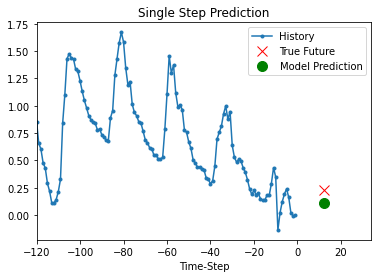

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(1):
    show_plot(
        [x[0].numpy(), y[0].numpy(), model.predict(x)[0]],
        12, # 12 hour or 0.5 day
        "Single Step Prediction",
    )

In [ ]:
# step = 6                # 1 hour
# past = 720              # 5 days
# future = 72             # 12 hour
pred_len = 360            # 2,5 days
n_val_steps = 463 # up calculate

plot_len = past + future + pred_len
print('Batch_size:', batch_size)
print('Step:', step)
print('Past:', past)
print('Future:', future)
print('Prediction length:', pred_len)
pred_len_step = int(pred_len/step)
print('Prediction length step:', pred_len_step)
plot_len_step = int(plot_len/step)
print('Plot length: {0} / {1} = {2:.2f}'.format(plot_len, step, plot_len/step))
n_val_samples = batch_size * n_val_steps
print('Number of validation samples:', n_val_samples)
val_space = n_val_samples + past - 1
print('Val space requirement:', val_space)
n_pred_samples = val_space - plot_len + 1
print('Number of samples for prediction:', n_pred_samples)
print('Unused number of samples:', n_val_samples - n_pred_samples)

Batch_size: 256
Step: 6
Past: 720
Future: 72
Prediction length: 360
Prediction length step: 60
Plot length: 1152 / 6 = 192.00
Number of validation samples: 118528
Val space requirement: 119247
Number of samples for prediction: 118096
Unused number of samples: 432


In [ ]:
predictions = np.zeros((n_pred_samples, pred_len_step))
# predictions = np.zeros((n_pred_samples, plot_len_step))
print('Predictions shape:', predictions.shape)
mae_score = np.zeros((n_pred_samples, pred_len_step))
print('MAE score shape:', mae_score.shape)

Predictions shape: (118096, 60)
MAE score shape: (118096, 60)


In [ ]:
from sklearn.metrics import mean_absolute_error
y_true = [6]
y_pred = [8]
mean_absolute_error(y_true, y_pred)

2.0

In [ ]:
%%time
not run
for i, (x_cur, y_cur) in enumerate(dataset_val.take(n_pred_samples)):
    print(i, end=' ')
    x_orig = x_cur[0].numpy()
    y_orig = y_cur[0].numpy()
    x_pred = np.zeros(x_orig.shape)
    # print(x_orig.shape)
    # print(y_orig.shape)
    # print(x_pred.shape)
    # print('y orig:', y_orig)
    
    for ind in range(pred_len_step):
        if ind != 0:
            x_pred[:-1] = x_pred[1:]
            x_pred[-1] = pred[0]
        else:
            x_pred[:] = x_orig[:]
        
        pred = model.predict(np.expand_dims(x_pred, axis=0))[0]
        mae_score[i, ind] = mean_absolute_error(y_orig, pred)
        # print(pred)
        # break

    # predictions[i] = np.ravel(x_pred[-pred_len_step:]) * data_std + data_mean
    predictions[i] = np.ravel(x_pred[-pred_len_step:]) * data_std + data_mean
    # print(predictions[i])
    # print(predictions[i].shape)  
    # print(mae_score[i])
    # print(mae_score[i].shape) 
    # break   

CPU times: user 21min 7s, sys: 32.8 s, total: 21min 39s
Wall time: 20min 55s


In [ ]:
plot_samples = np.zeros((n_pred_samples, plot_len_step))
print('plot_samples.shape:', plot_samples.shape)

for i in range(n_pred_samples):
    plot_samples[i] = df['T (degC)'].iloc[train_split+i : train_split+i+plot_len : 6].values.copy()  

print(plot_samples[0].shape)
print(plot_samples[1].shape)

plot_samples.shape: (118096, 192)
(192,)
(192,)


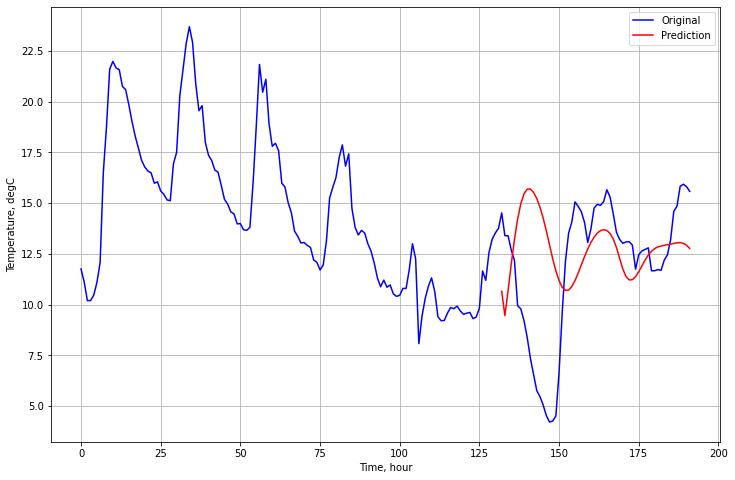

In [ ]:
# plot_ind = 0
plot_ind = plot_ind + 1
plt.figure(figsize=(12,8))
plt.plot(range(plot_len_step), plot_samples[plot_ind], "b", label="Original")
plt.plot(range((past+future)//6, plot_len_step), predictions[plot_ind], "r", label="Prediction")
# plt.plot(range(plot_len_step), predictions[plot_ind], "r", label="Prediction")
plt.xlabel("Time, hour")
plt.ylabel("Temperature, degC")
plt.grid(True)
plt.legend()
plt.show()

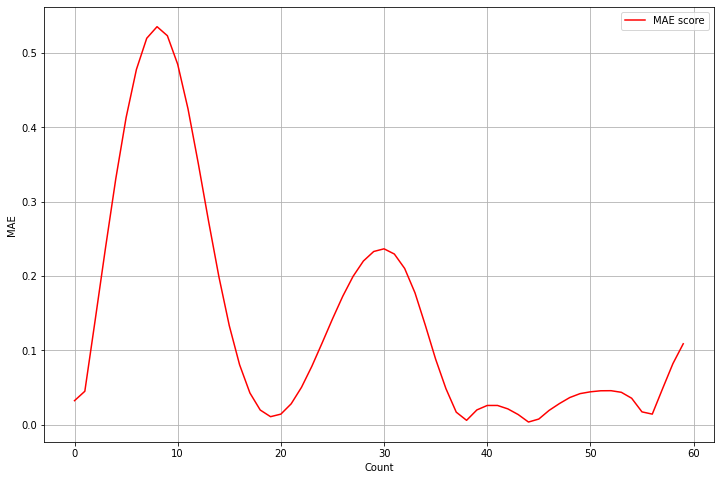

In [ ]:
# plot_ind = 0
plot_ind = plot_ind + 1
plt.figure(figsize=(12,8))
plt.plot(range(pred_len_step), mae_score[plot_ind], "r", label="MAE score")
plt.xlabel("Count")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
mean_mae_score = mae_score.mean(axis=0)
print(mean_mae_score)

[0.00113305 0.0011369  0.0011727  0.00124512 0.00134696 0.00145913
 0.00157046 0.00167492 0.00176714 0.00184237 0.00189607 0.00192748
 0.00193773 0.0019249  0.00189437 0.00185226 0.0018003  0.00174305
 0.00168905 0.00164149 0.00160391 0.0015783  0.00156454 0.00156544
 0.00157689 0.00159587 0.0016236  0.00165786 0.00169877 0.00174321
 0.00178922 0.00183564 0.00187533 0.00190684 0.00192868 0.00194303
 0.00195171 0.00195515 0.00195346 0.00194847 0.00194043 0.00193662
 0.00193575 0.00193749 0.00194404 0.00195359 0.00196729 0.00198531
 0.00200556 0.00202475 0.00204738 0.00206955 0.00209258 0.00211664
 0.00214095 0.00216254 0.00218061 0.00219471 0.00220337 0.00220623]


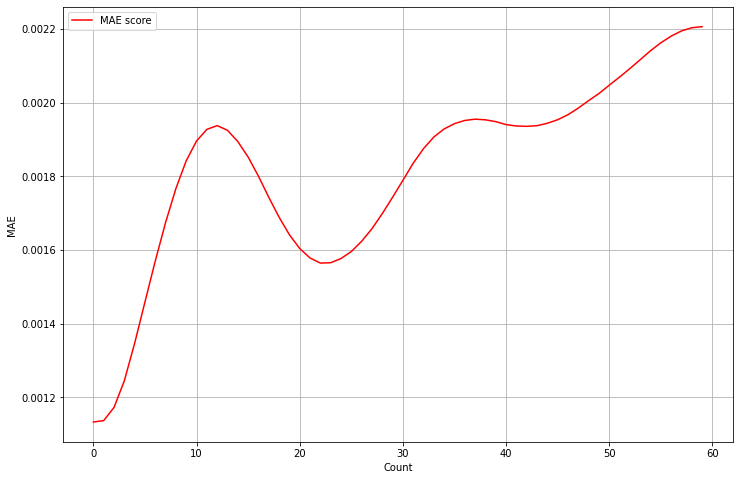

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(pred_len_step), mean_mae_score, "r", label="MAE score")
plt.xlabel("Count")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
arr = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
print(arr.shape)
a_mean = arr.mean(axis=1)
print(a_mean)
print(arr)

(2, 5)
[3. 3.]
[[1 2 3 4 5]
 [1 2 3 4 5]]


In [ ]:
arr_trans = arr.transpose()
print(arr_trans.shape)
# print(arr_trans)
a_trans = arr_trans.mean(axis=0)
print(a_trans)

(5, 2)
[3. 3.]


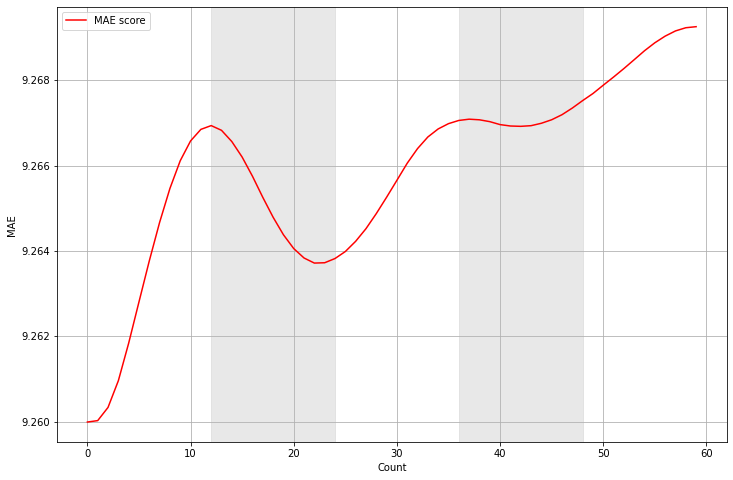

In [ ]:
t_mean_mae_score = mae_score.mean(axis=0) * data_std + data_mean
plt.figure(figsize=(12,8))
plt.plot(range(pred_len_step), t_mean_mae_score, "r", label="MAE score")
plt.axvspan(12, 24, alpha=0.5, color='lightgrey')
plt.axvspan(36, 48, alpha=0.5, color='lightgrey')
plt.xlabel("Count")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.show()